# Get a dict of sky value for every stamp

Dict saves the Field->band->mjd->sky of every stamp

In [1]:
#python 2 and 3 comptibility
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import json
import io
import gzip
import base64
from astropy.io import fits
import matplotlib.pylab as plt
import pickle as pkl
import numpy as np
import sys 
import os
%matplotlib inline

PATH_TO_PROJECT = os.path.abspath(
    os.path.join(os.path.dirname('__file__'), ''))
sys.path.append(PATH_TO_PROJECT)
sys.path.append(os.path.join(PATH_TO_PROJECT,'..'))

data_path = '../AlerceDHtest/datasets/ZTF'

path = data_path+'/broker_reals.json'
with open(path, "r") as f:
        dataset = json.load(f)

In [2]:
type(dataset)
dataset.keys()

dict_keys(['query_result'])

In [3]:
len(dataset['query_result'])

7410

In [4]:
dataset['query_result'][0].keys()

dict_keys(['_id', 'objectId', 'candid', 'candidate', 'prv_candidates', 'cutoutScience', 'cutoutTemplate', 'cutoutDifference'])

In [5]:
dataset['query_result'][0]['objectId']

'ZTF17aaaiikr'

In [6]:
#build dict by alert id
alerts = {}
passbands = ["g", "r", "i"]
for alert in dataset["query_result"]:
    dict_in_stamp = {'science_stamp':None, 'filter': None, 'fwhm': None, 'mjd': None, 'field': None}
    #get params to save in dict
    dict_in_stamp['filter'] = passbands[alert["candidate"]["fid"]-1]
    dict_in_stamp['fwhm'] = alert["candidate"]["fwhm"]
    dict_in_stamp['mjd'] = alert["candidate"]["jd"]
    dict_in_stamp['field'] = alert["candidate"]["field"]
    stamp = alert['cutoutScience']['stampData']
    stamp = base64.b64decode(stamp["$binary"].encode())
    with gzip.open(io.BytesIO(stamp), 'rb') as f:
        with fits.open(io.BytesIO(f.read())) as hdul:
            img = hdul[0].data
    dict_in_stamp['science_stamp'] = img
    
    stamp_id = alert["_id"]
    
    if stamp_id in alerts.keys():
        print(stamp_id)
        continue
    else:
        alerts[stamp_id] = dict_in_stamp

In [7]:
len(list(alerts.keys()))

7410

In [8]:
def createCircularMask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])
    radius = np.round(radius)
    
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [9]:
# add masked sky and sky array to dicts
n_sigmas = 4

#check if values are already in dict, to avoid second innecesarry runs
if 'masked_sky' not in alerts[list(alerts.keys())[0]].keys():
    for alert_id in alerts:
        alert = alerts[alert_id] 
        fw = alert['fwhm']
        mask = ~createCircularMask(alert['science_stamp'].shape[0], alert['science_stamp'].shape[1], radius=n_sigmas*(fw/2.35482))
        masked_sky = alert['science_stamp']*mask
        alert['masked_sky'] = masked_sky

        sky_pixels_cord = np.argwhere(mask==True)
        sky_pixels = np.array([masked_sky[cord[0],cord[1]] for cord in list(sky_pixels_cord)])
        alert['sky_pixel_values'] = sky_pixels

In [53]:
#class to filter sky without considering nans
class Sky_filter:

    def __init__(self, sky_pixels, n_sigma=2, filter_iterations=5):
        
        self.n = n_sigma
        self.sigmas = np.empty((0))
        self.n_sigmas = np.empty((0))
        self.sky_pixels = sky_pixels[np.logical_not(np.isnan(sky_pixels))]      
        
    def get_n_sigma(self, sky_pixels):
        sigma = np.std(sky_pixels)
        #print(np.mean(sky_pixels))
        #print(np.mean(sky_pixels)+sigma)
        n_sigma = np.mean(sky_pixels)+self.n*sigma
        self.sigmas = np.append(self.sigmas,np.mean(sky_pixels)+sigma)
        self.n_sigmas = np.append(self.n_sigmas,n_sigma)
        return n_sigma
    
    def filter_sky_once(self):
        last_filtered_sky = self.filtered_sky['it%i'%(len(list(self.filtered_sky.keys()))-1)]
        n_sigma = self.get_n_sigma(last_filtered_sky)
        pixels_over_sigma = np.abs(last_filtered_sky)>n_sigma
        pixels_over_std_cord = np.argwhere(pixels_over_sigma==True)
        #print(pixels_over_std_cord)
        new_filtered_sky = np.delete(last_filtered_sky, pixels_over_std_cord)
        self.filtered_sky['it%i'%len(list(self.filtered_sky.keys()))] = new_filtered_sky
        
    def iterative_filtering(self, iterations):
        #print(self.sky_pixels.shape)
        if np.isnan(self.sky_pixels).any():
            return None
            
        self.sigmas = np.empty((0))
        self.n_sigmas = np.empty((0))
        self.filtered_sky = {'it0':self.sky_pixels}
        for i in range(iterations):
            self.filter_sky_once()
        return self.filtered_sky

    def check_availability(self, array, idx):
        array = np.array(array)
        if array.shape[0]-1<idx:
            check_nans = self.iterative_filtering(idx+1)
        if check_nans is None:
            raise ValueError('nans in sky pixels')
            
    def plot_array(self, array):
        array = np.array(array)
        x = np.arange(0, array.shape[0])
        plt.plot(x,array)
            
    def plot_filtered_sky_sigmas(self, idx=0, x_pos=32, y_pos=32):
        self.check_availability(self.n_sigmas, idx)
        
        #plt.figure(figsize=(12,12))
        line = np.arange(0,self.sky_pixels.shape[0])
        n_sigma_line = np.full(self.sky_pixels.shape[0], self.n_sigmas[idx])
        mean = np.full(self.sky_pixels.shape[0], np.mean(self.sky_pixels))
        plt.scatter(line, self.sky_pixels)
        #plt.lim(np.min(self.sky_pixels),np.max(self.sky_pixels))
        plt.plot(line, n_sigma_line, color='black', label='sigma')
        plt.plot(line, mean, '--', color='black', label='mean')
        #print(self.sky_pixels)
        #print(self.sky_pixels.shape)
        plt.title(r'non-filtered $\sigma$[%f], max: %f'%(self.n_sigmas[idx].round(decimals=3), np.max(self.sky_pixels)))
        plt.legend()
        plt.show()

        filtered_sky = self.filtered_sky['it%i'%idx]
        line = np.arange(0,filtered_sky.shape[0])
        n_sigma_line = np.full(filtered_sky.shape[0], self.n_sigmas[idx])
        mean = np.full(filtered_sky.shape[0], np.mean(filtered_sky))
        plt.scatter(line, filtered_sky)
        plt.plot(line, n_sigma_line, color='black', label='sigma')
        plt.plot(line, mean, '--', color='black', label='mean')
        plt.title(r'filtered $\sigma$['+str(idx)+r']: '+str(self.n_sigmas[idx].round(decimals=3)))
        plt.legend()
        plt.show()
        
        self.plot_array(self.n_sigmas)
        plt.title(r'$\sigma$´s progretions')
        plt.show()

[222.3865  223.05894 223.8122  ... 349.1618  377.5494  446.41638]


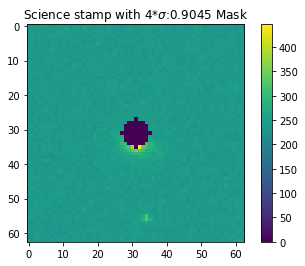

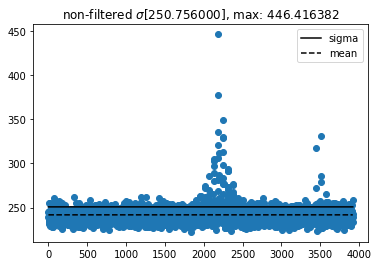

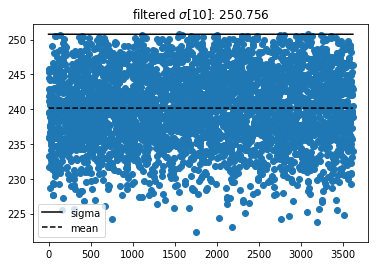

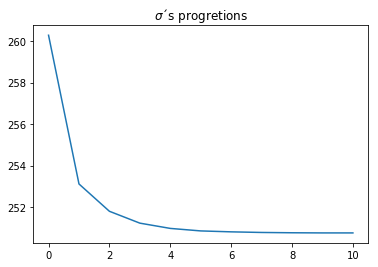

In [54]:
#sky filter example
alert_id = 1242
sky_values = alerts[list(alerts.keys())[alert_id]]['sky_pixel_values']
print(np.sort(sky_values))
sky_filter = Sky_filter(sky_values)
plt.imshow(alerts[list(alerts.keys())[alert_id]]['masked_sky'])
plt.title(r'Science stamp with %i*$\sigma$:%0.4f Mask' %(n_sigmas, (alerts[list(alerts.keys())[alert_id]]['fwhm']/2.35482)))
plt.colorbar()
plt.show()
sky_filter.plot_filtered_sky_sigmas(idx=10)

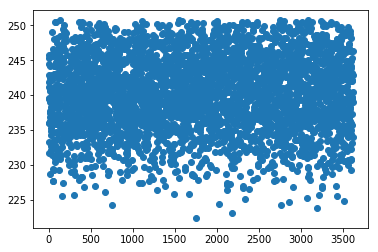

In [55]:
#get filtered sky above example
sky_values = alerts[list(alerts.keys())[alert_id]]['sky_pixel_values']
#print(np.sort(sky_values))
sky_filter = Sky_filter(sky_values)
filtered_sky = sky_filter.iterative_filtering(iterations=10)
plt.scatter(np.arange(0,filtered_sky[list(filtered_sky.keys())[-1]].shape[0]), filtered_sky[list(filtered_sky.keys())[-1]])
plt.show()

In [56]:
len(list(alerts.keys()))

7410

In [57]:
alerts[list(alerts.keys())[alert_id]].keys()

dict_keys(['science_stamp', 'filter', 'fwhm', 'mjd', 'field', 'masked_sky', 'sky_pixel_values'])

In [62]:
# add filtered sky (after filter_iterations iterations) to dict
filter_iterations = 10

#check if values are already in dict, to avoid second innecesarry runs
if 'filtered_sky_pixel_values' not in alerts[list(alerts.keys())[0]].keys():
    #i=0
    for alert_id in alerts:
        #print(i)
        #i+=1
        alert = alerts[alert_id] 
        sky_values = alert['sky_pixel_values']
        sky_filter = Sky_filter(sky_values)
        filtered_sky = sky_filter.iterative_filtering(iterations=filter_iterations)
        #get last iteration filtered sky
        last_iteration_filtered_sky = filtered_sky[list(filtered_sky.keys())[-1]]
        mean_sky_value = np.mean(last_iteration_filtered_sky)
        #add data to dict
        alert['filtered_sky_pixel_values'] = last_iteration_filtered_sky
        alert['sky_value'] = mean_sky_value

In [63]:
alerts[alert_id].keys()

dict_keys(['science_stamp', 'filter', 'fwhm', 'mjd', 'field', 'masked_sky', 'sky_pixel_values', 'filtered_sky_pixel_values', 'sky_value'])

# Plot sky value, grouped by mjd

In [68]:
# get all mjd
all_mjd = []
for alert_id in alerts:
    alert = alerts[alert_id] 
    mjd = alert["mjd"]
    all_mjd.append(mjd)
all_mjd = np.unique(all_mjd)
all_mjd.shape

(2405,)

In [73]:
#group alerts by mjd
sky_values_groped_by_mjd = {}
for mjd in all_mjd:
    sky_values_groped_by_mjd[mjd] = []
    for alert_id in alerts:
        alert = alerts[alert_id]
        if alert['mjd']==mjd:
            sky_values_groped_by_mjd[mjd].append(alert['sky_value'])

In [77]:
#verify correct extraction of mjd
alert_count = 0
for mjd in sky_values_groped_by_mjd:
    alert_count += len(sky_values_groped_by_mjd[mjd])
    #print('mjd:%.4f; n_alerts_in_mjd:%i alert_count : %i' %(mjd, len(sky_values_groped_by_mjd[mjd]), alert_count))
#sky_values_groped_by_mjd.keys()

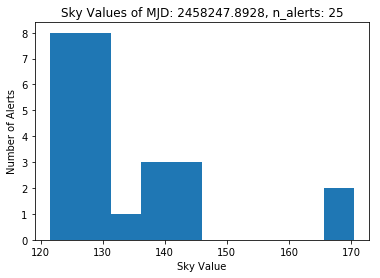

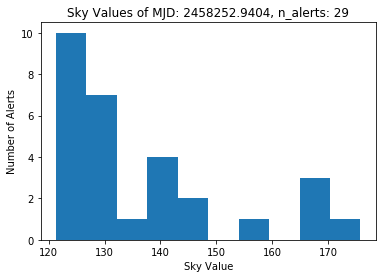

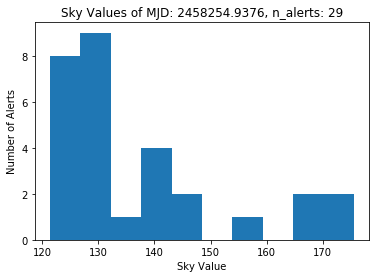

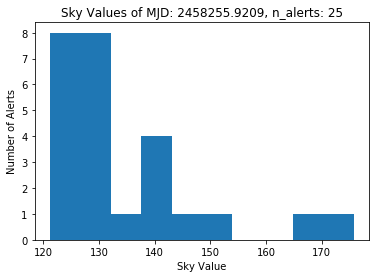

In [86]:
# plot histograms tih more than n_points of mjd
n_mjd_points = 20

for mjd in sky_values_groped_by_mjd:
    if len(sky_values_groped_by_mjd[mjd])>=n_mjd_points:
        plt.hist(sky_values_groped_by_mjd[mjd])
        plt.title('Sky Values of MJD: %.4f, n_alerts: %i'%(mjd, len(sky_values_groped_by_mjd[mjd])))
        plt.xlabel('Sky Value')
        plt.ylabel('Number of Alerts')
        plt.show()

# plot samples

0


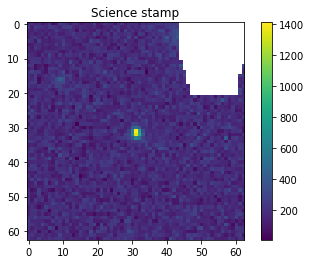

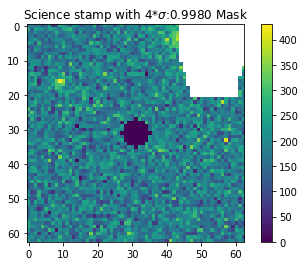

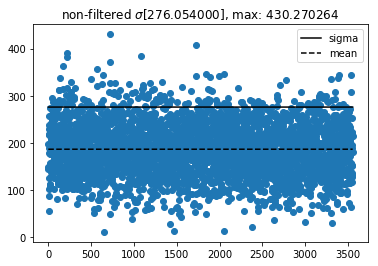

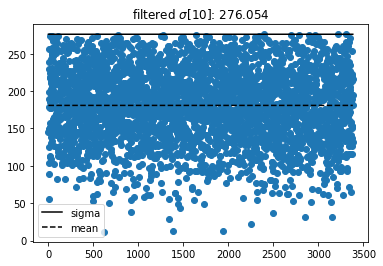

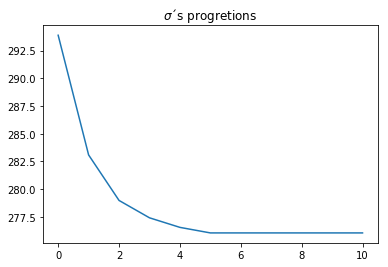

1


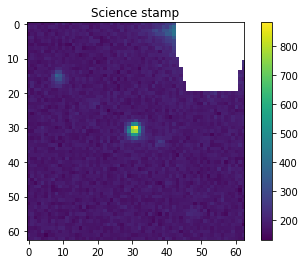

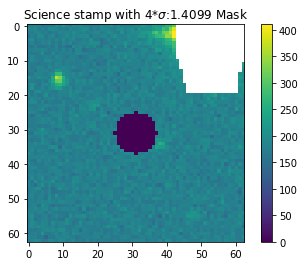

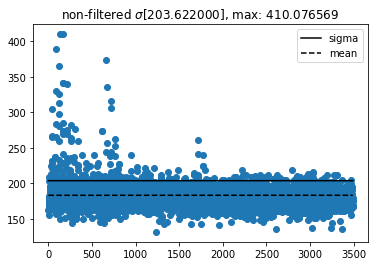

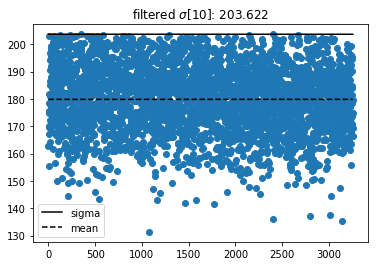

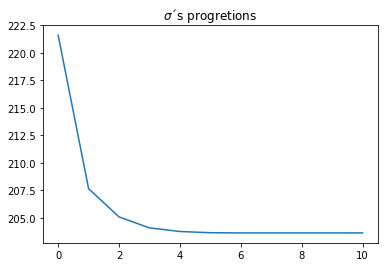

2


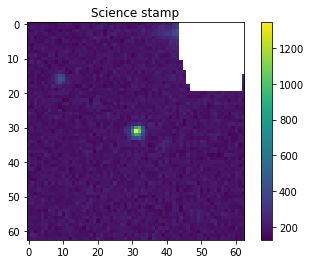

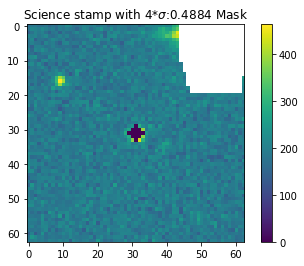

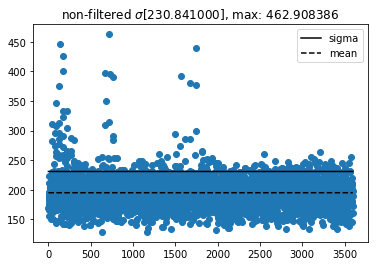

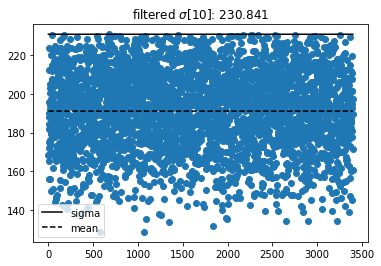

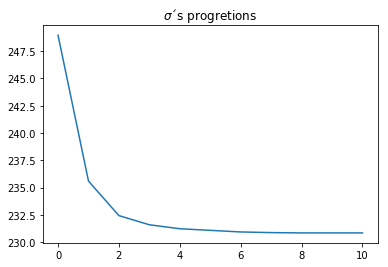

3


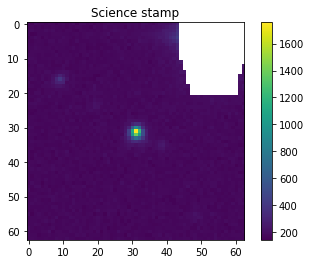

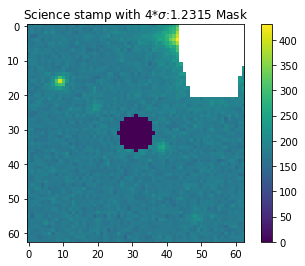

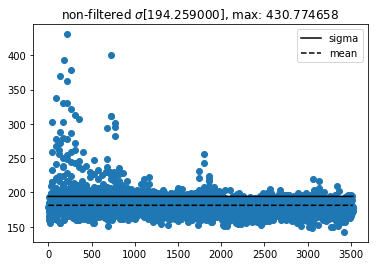

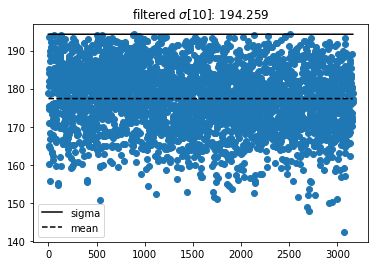

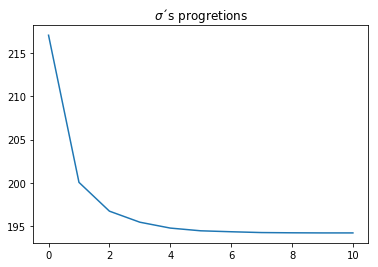

4


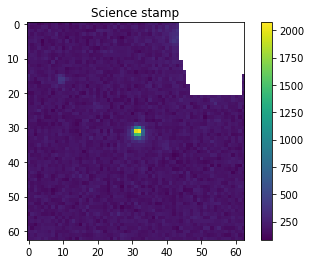

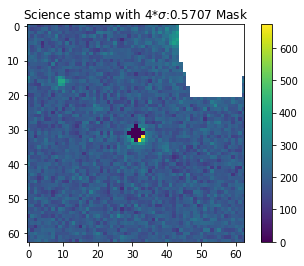

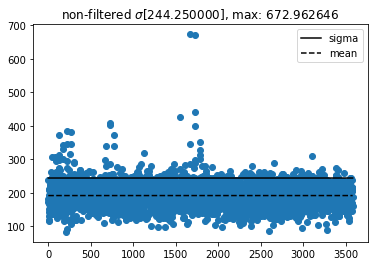

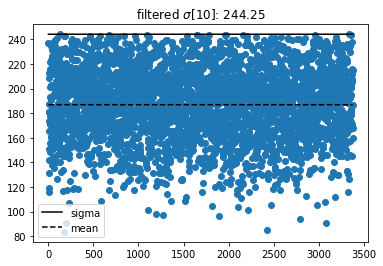

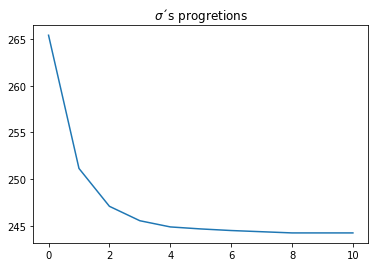

5


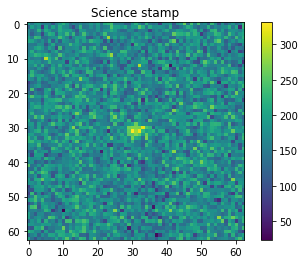

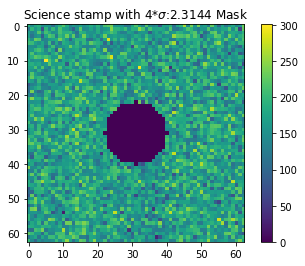

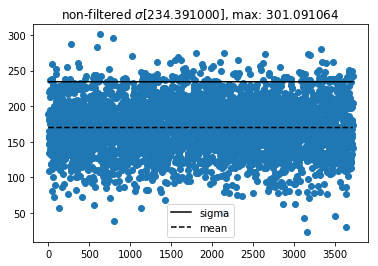

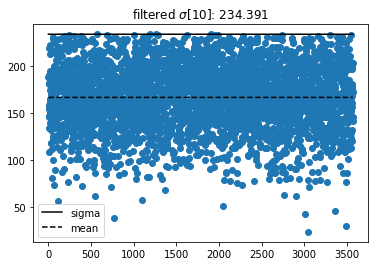

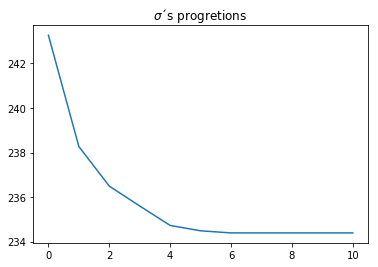

6


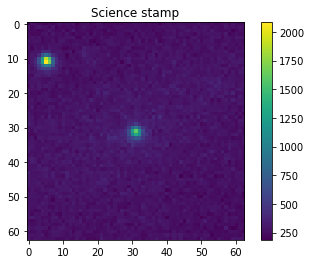

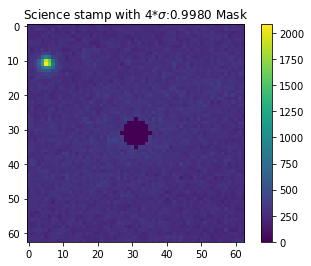

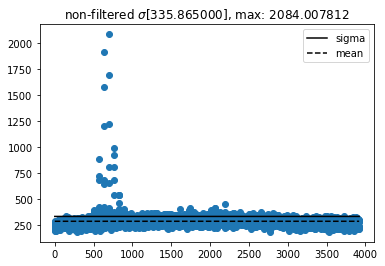

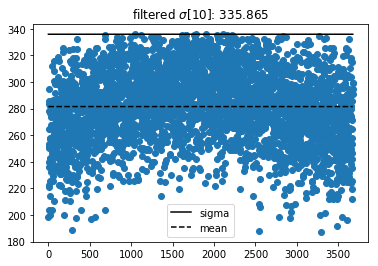

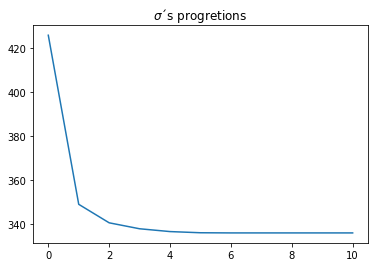

7


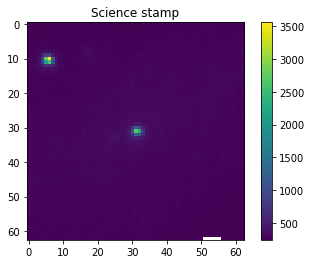

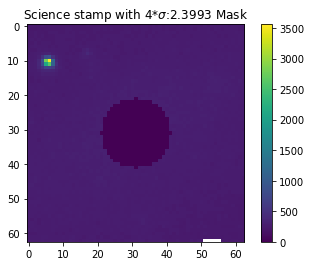

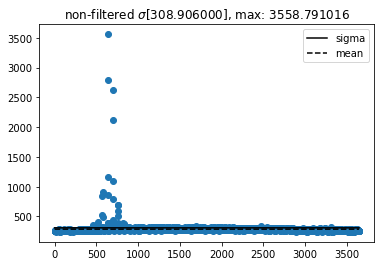

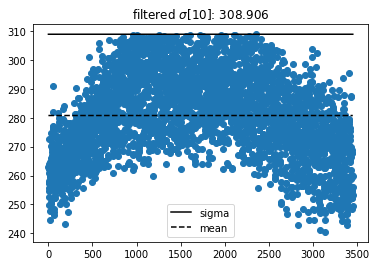

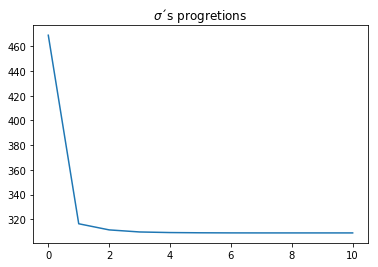

8


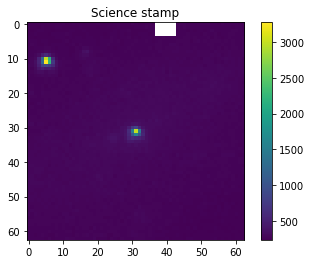

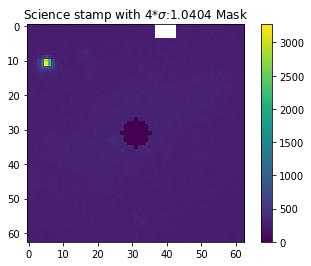

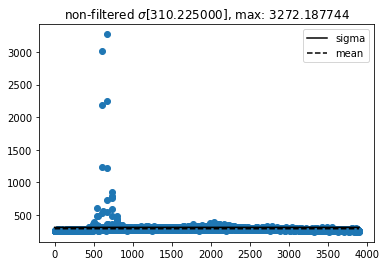

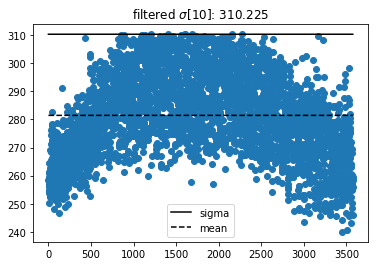

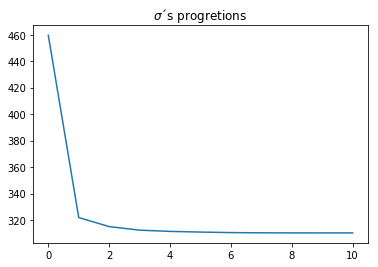

9


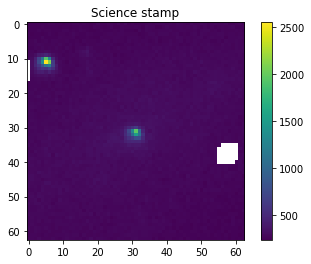

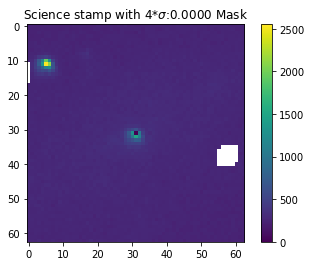

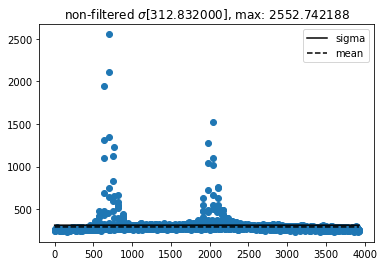

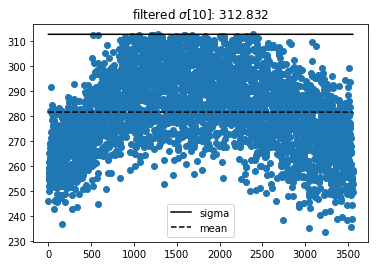

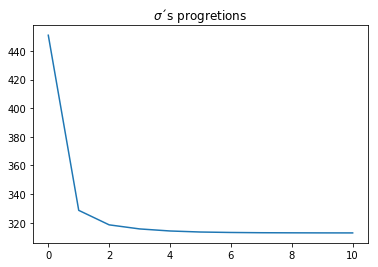

10


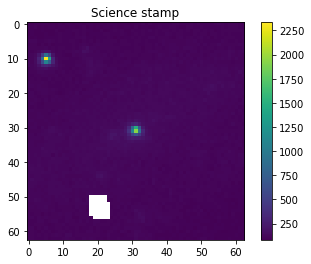

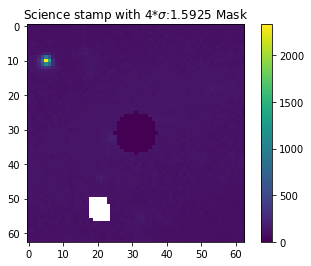

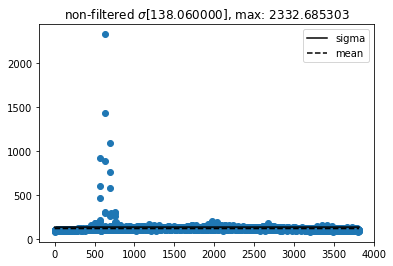

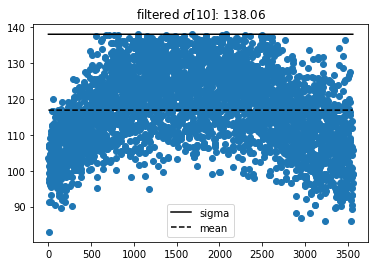

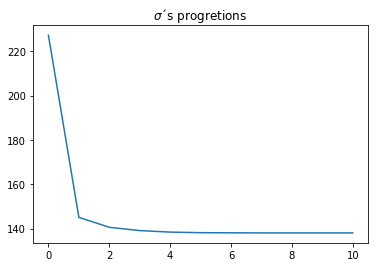

11


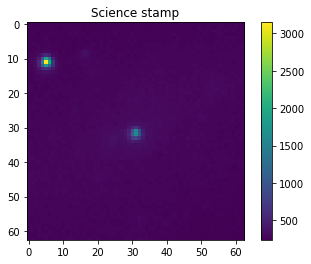

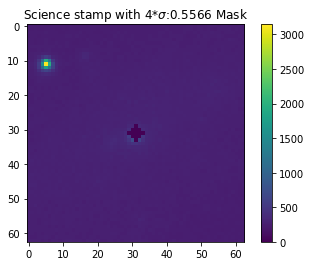

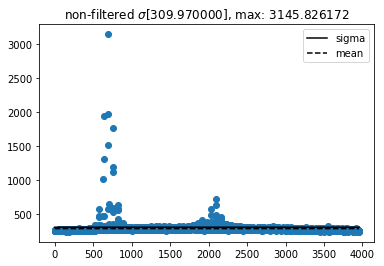

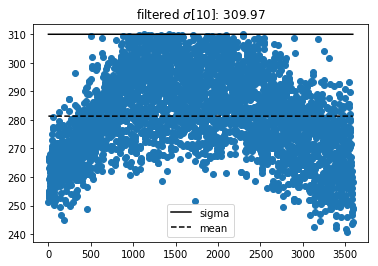

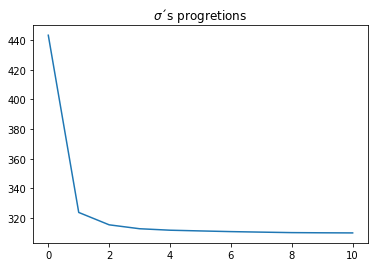

12


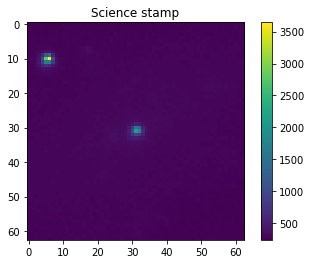

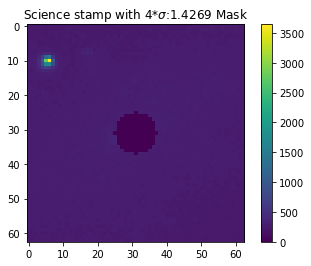

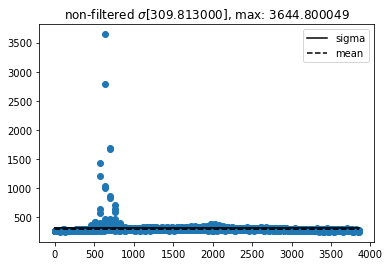

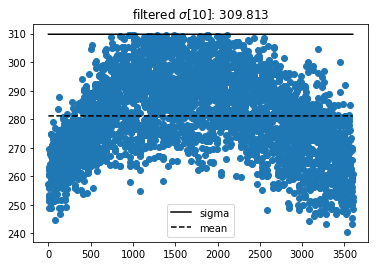

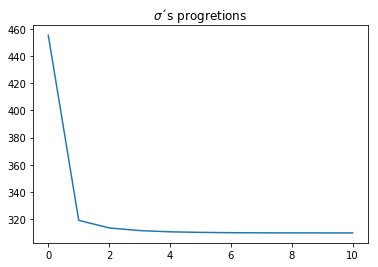

13


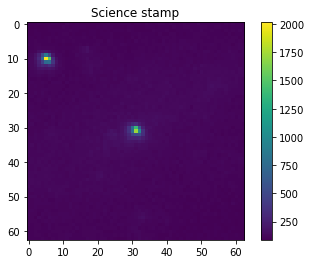

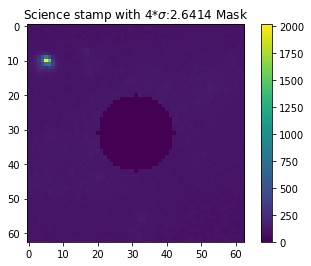

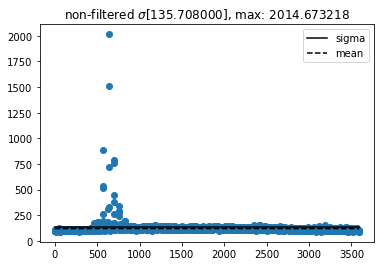

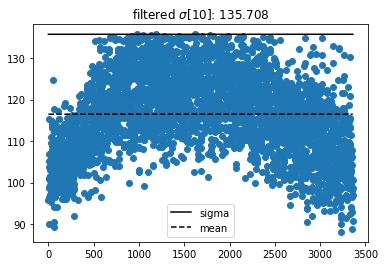

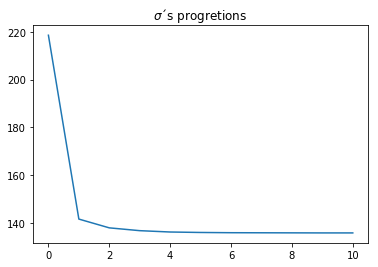

14


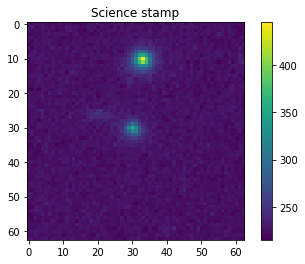

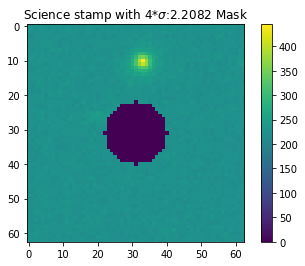

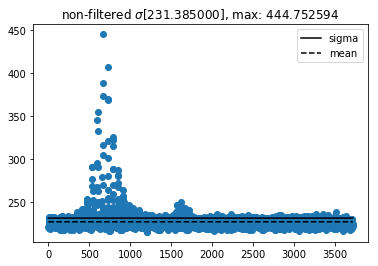

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [60]:
# plot samples
i=0
for alert_id in alerts:
    print(i)
    i+=1
    alert = alerts[alert_id] 
    sky_values = alert['sky_pixel_values']
    sky_filter = Sky_filter(sky_values)
    filtered_sky = sky_filter.iterative_filtering(iterations=filter_iterations)

    plt.imshow(alert['science_stamp'])
    plt.colorbar()
    plt.title('Science stamp')
    plt.show()
    plt.imshow(alert['masked_sky'])
    plt.colorbar()
    plt.title(r'Science stamp with %i*$\sigma$:%0.4f Mask' %(n_sigmas, (alert['fwhm']/2.35482)))
    plt.show()
    sky_filter.plot_filtered_sky_sigmas(idx=filter_iterations)

In [ ]:
#see non square stamps
"""
i=0
for alert_id in alerts:
    print(i)
    alert = alerts[alert_id]
    print((alert['science_stamp'].shape))
    print((alert['masked_sky'].shape),"\n")
    if alert['science_stamp'].shape[0]!=alert['masked_sky'].shape[1]:
        break
    i+=1
"""